In [31]:
import os
import glob
import librosa
import numpy as np
import soundfile as sf

def clipping(filename, outputfile, percentile_threshold=10.0):
        samples, fs = librosa.load(filename, sr=None)
        lower_percentile_threshold = percentile_threshold/2
        #print(lower_percentile_threshold)
        lower_threshold, upper_threshold = np.percentile(
                samples, [lower_percentile_threshold, 100 - lower_percentile_threshold])
        #print(lower_threshold)
        #print(upper_threshold)
        samples = np.clip(samples, lower_threshold, upper_threshold)
        #print(fs)
        sf.write(outputfile, samples,fs)
        #print("Clipping COMPLETED with percentile threshold: " +str(percentile_threshold))


input_folder = 'lt400'
output_folder = 'output_folder'
clipping_values = [ 1, 5, 10, 20, 30, 40]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for desired_clipping in clipping_values:
    output_folder = os.path.join(output_folder, f'clipping{desired_clipping}')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(output_folder, os.path.basename(file))
        clipping(file, output_filename, desired_clipping)

        

In [33]:
import os
import json
import wave
import sys
import json
from vosk import Model, KaldiRecognizer, SetLogLevel
import pandas as pd

def transcribe_files_to_tsv(input_folder, output_filename):
    # Set the log level to 0 to disable debug messages
    SetLogLevel(0)

    model = Model(lang="ca")
    transcriptions = []

    # Iterate through all files in the input folder
    for file in os.listdir(input_folder):
        #print(os.path.basename(file))
        if file.endswith(".wav"):
            wf = wave.open(os.path.join(input_folder, file), "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                print(f"Audio file {file} must be WAV format mono PCM.")
                continue

            rec = KaldiRecognizer(model, wf.getframerate())
            rec.SetWords(True)
            rec.SetPartialWords(True)

            # Process the audio file
            last = None
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break      
                if rec.AcceptWaveform(data):
                    last = rec.Result()
                else:
                    rec.PartialResult()             
                #if rec.AcceptWaveform(data):
                    
            result_json = rec.Result()
            result_dict = json.loads(result_json)
            if(result_dict["text"] == ""):
                try:
                    result_dict = json.loads(last)   
                except:
                    print("Error") 
            #results = result_dict["result"]
            #print(os.path.basename(file)+"saved")
            transcriptions.append((os.path.basename(file), result_dict["text"]))
            #print(result_dict["text"])
                    

    # Convert the list of transcriptions to a DataFrame
    transcriptions_df = pd.DataFrame(transcriptions, columns=['filename', 'transcription'])

    # Save the output to a TSV file
    transcriptions_df.to_csv(output_filename, sep="\t", index=False)

#transcribe_files_to_tsv("lt400/", "lt400.tsv")
transcribe_files_to_tsv("clipping1/", "clipping1.tsv")
# transcribe_files_to_tsv("clipping5/", "clipping5.tsv")
# transcribe_files_to_tsv("clipping10/", "clipping10.tsv")
# transcribe_files_to_tsv("clipping20/", "clipping20.tsv")
# transcribe_files_to_tsv("clipping30/", "clipping30.tsv")
# transcribe_files_to_tsv("clipping40/", "clipping40.tsv")


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/graph/HCLr.fst /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo /

In [34]:
import csv
from pathlib import Path
from jiwer import wer
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from scipy.io import wavfile
import warnings
from pesq import cypesq
import torch
import librosa

# Suppress the specific warning messages
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).")

def read_audio_file(file_path):
    data, fs = librosa.load(file_path, sr=16000)
    data = torch.tensor(data, dtype=torch.float32)
    return fs, data

def calculate_pesq(fs, ref_audio, deg_audio, mode):
    # Detach the tensors from the computation graph and move them to the CPU
    ref_audio_detached = ref_audio.detach().cpu()
    deg_audio_detached = deg_audio.detach().cpu()
    
    try:
        # Call the perceptual_evaluation_speech_quality function with PyTorch tensors
        return perceptual_evaluation_speech_quality(ref_audio_detached, deg_audio_detached, fs, mode)
    except cypesq.NoUtterancesError:
        print("No utterances detected in the input audio files.")
        return 1

def pesq_from_paths(ref_file_path, deg_file_path):
    fs_ref, ref_audio = read_audio_file(ref_file_path)
    fs_deg, deg_audio = read_audio_file(deg_file_path)
    # Ensure the sampling frequencies are the same
    assert fs_ref == fs_deg, "Sampling frequencies must be the same" + str(fs_ref) + str(fs_deg)

    # Choose the mode based on the sampling frequency
    mode = 'wb' if fs_ref == 16000 else 'nb'

    if len(ref_audio) > len(deg_audio):
        pad_length = len(ref_audio) - len(deg_audio)
        deg_audio = torch.cat([deg_audio, torch.zeros(pad_length, dtype=torch.float32)])
    elif len(ref_audio) < len(deg_audio):
        deg_audio = deg_audio[:len(ref_audio)]

    # Calculate PESQ score
    pesq_score = calculate_pesq(fs_ref, ref_audio, deg_audio, mode)
    return pesq_score

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer_pesq(original_data, augmented_data, output_file_path, clipping):
    # Calculate WER and PESQ for each file
    output = []
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            ref_file_path = f"{ORIGINAL_FOLDER}/{filename}"
            deg_file_path = f"{augmented_folder}/{filename}"
            print(ref_file_path + "  " + deg_file_path)
            try:
                wer_score = wer(original_transcription, augmented_transcription)
            except:
                wer_score = 1
            pesq_score = pesq_from_paths(ref_file_path, deg_file_path)
            #print("PESQ "+ str(pesq_score)+"WER "+str(wer_score))
            output.append([filename, wer_score, str(pesq_score).replace("tensor(", "").replace(")", ""), clipping])
        else:
            print(f"No augmented transcription found for file {filename}")
    # Save the output to a TSV file
    with open(output_file_path, "w", newline="") as file:
        writer = csv.writer(file, delimiter="\t")
        writer.writerow(["Filename", "WER", "PESQ", "clipping"])
        writer.writerows(output)


ORIGINAL_FOLDER = "lt400"
augmented_folder = "clipping5"

tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)


# clipping5_path = Path("clipping5/clipping5.tsv")
# clipping5 = read_tsv_file(clipping5_path)


# output_clipping5 = Path("OUTPUT5CLIP.tsv")


# calculate_wer_pesq(tsv_data, clipping5, output_clipping5,5)

augmented_folder = "clipping1"
clipping1_path = Path("clipping1/clipping1.tsv")
clipping1 = read_tsv_file(clipping1_path)
output_clipping1 = Path("OUTPUT1CLIP.tsv")

calculate_wer_pesq(tsv_data, clipping1, output_clipping1,1)

# augmented_folder = "clipping10"
# clipping10_path = Path("clipping10/clipping10.tsv")
# clipping10 = read_tsv_file(clipping10_path)
# output_clipping10 = Path("OUTPUT10CLIP.tsv")

# calculate_wer_pesq(tsv_data, clipping10, output_clipping10,10)


# augmented_folder = "clipping20"
# clipping20_path = Path("clipping20/clipping20.tsv")
# clipping20 = read_tsv_file(clipping20_path)
# output_clipping20 = Path("OUTPUT20CLIP.tsv")

# calculate_wer_pesq(tsv_data, clipping20, output_clipping20,20)

# augmented_folder = "clipping30"
# clipping30_path = Path("clipping30/clipping30.tsv")
# clipping30 = read_tsv_file(clipping30_path)
# output_clipping30 = Path("OUTPUT30CLIP.tsv")

# calculate_wer_pesq(tsv_data, clipping30, output_clipping30,30)

# augmented_folder = "clipping40"
# clipping40_path = Path("clipping40/clipping40.tsv")
# clipping40 = read_tsv_file(clipping40_path)
# output_clipping40 = Path("OUTPUT40CLIP.tsv")

# calculate_wer_pesq(tsv_data, clipping40, output_clipping40,40)



lt400/common_voice_ca_31378986.wav  clipping1/common_voice_ca_31378986.wav
PESQ tensor(3.8290)WER 0.0
lt400/common_voice_ca_31340819.wav  clipping1/common_voice_ca_31340819.wav
PESQ tensor(3.9499)WER 0.0
lt400/upc_ca_pau_101129.wav  clipping1/upc_ca_pau_101129.wav
PESQ tensor(4.1252)WER 0.0
lt400/upc_ca_pau_101059.wav  clipping1/upc_ca_pau_101059.wav
PESQ tensor(3.9627)WER 0.025
lt400/common_voice_ca_31169713.wav  clipping1/common_voice_ca_31169713.wav
PESQ tensor(4.2717)WER 0.09090909090909091
lt400/common_voice_ca_30791849.wav  clipping1/common_voice_ca_30791849.wav
PESQ tensor(3.8442)WER 0.1
lt400/common_voice_ca_31083166.wav  clipping1/common_voice_ca_31083166.wav
PESQ tensor(3.6438)WER 0.0
lt400/common_voice_ca_31792858.wav  clipping1/common_voice_ca_31792858.wav
PESQ tensor(4.1831)WER 0.2
lt400/upc_ca_pau_101070.wav  clipping1/upc_ca_pau_101070.wav
PESQ tensor(4.0844)WER 0.0
lt400/common_voice_ca_31148020.wav  clipping1/common_voice_ca_31148020.wav
PESQ tensor(4.1865)WER 0.0
lt40

PESQ tensor(4.6439)


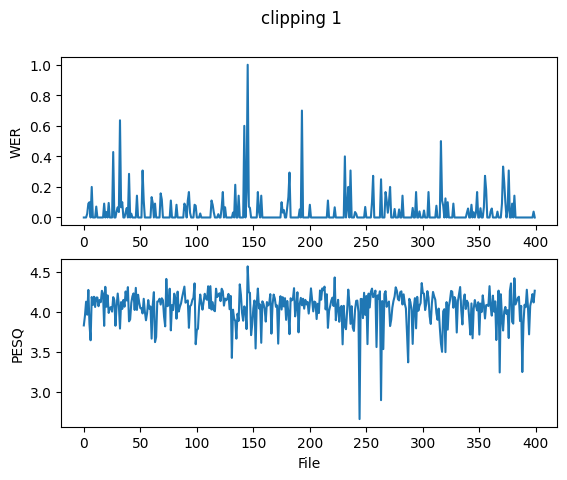

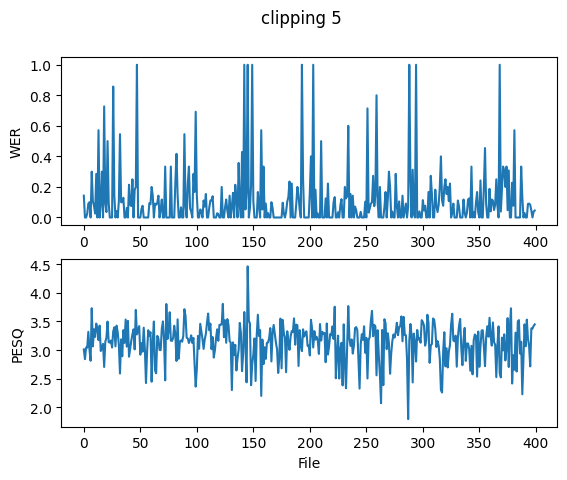

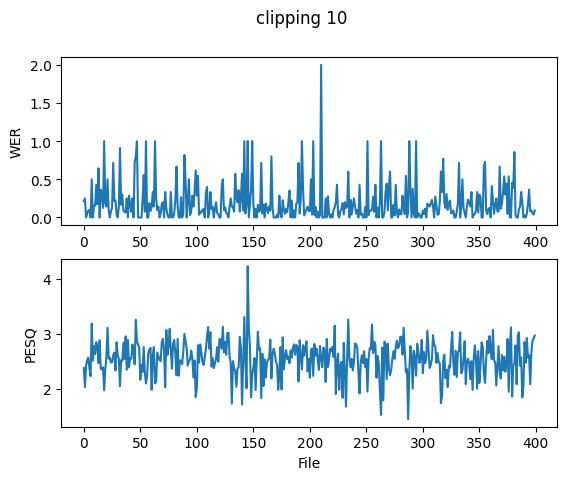

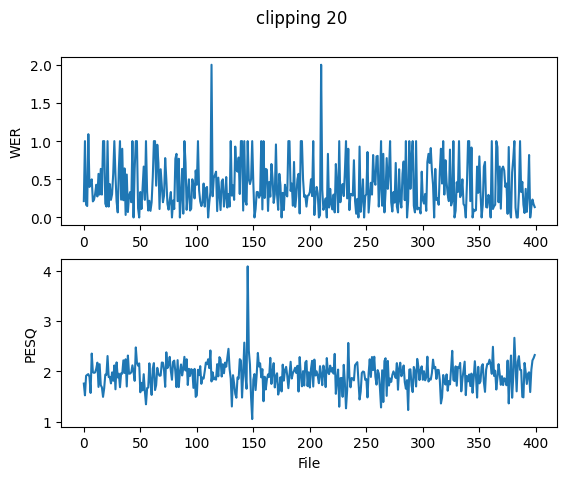

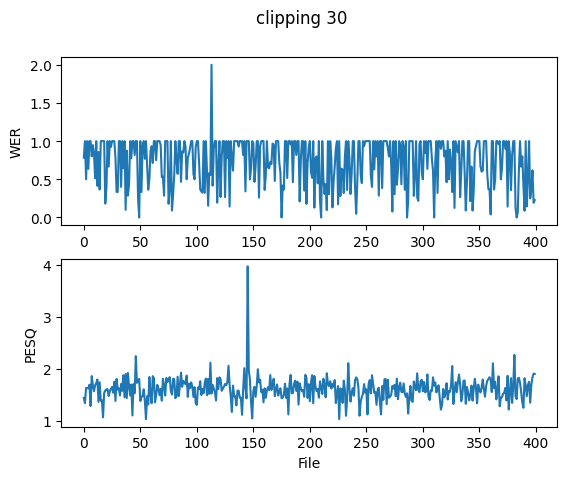

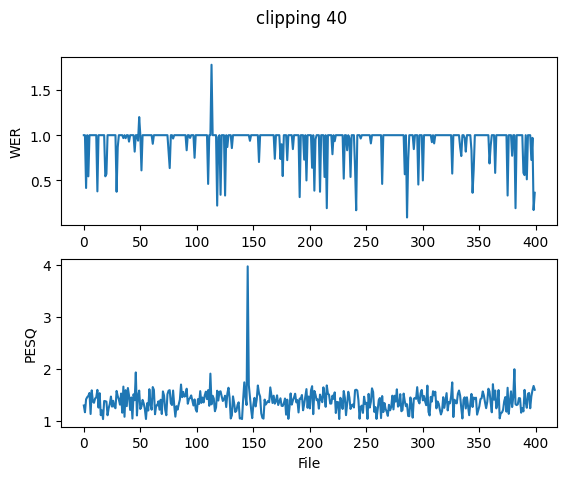

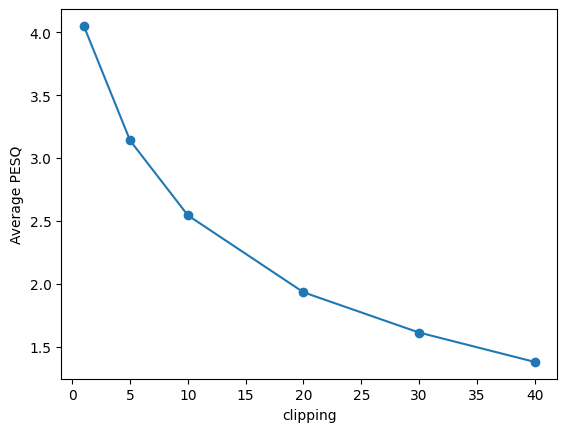

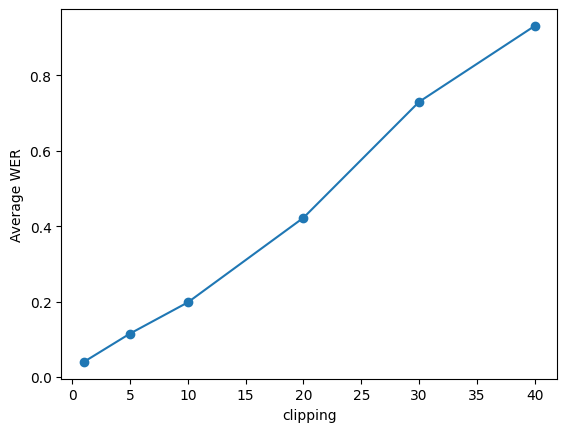

({40: {'WER': 0.9312823524338592, 'PESQ': 1.3798522500000001}},
 {40: {'WER': [1.0,
    1.0,
    0.4166666666666667,
    1.0,
    0.5454545454545454,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    0.3793103448275862,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    0.5454545454545454,
    0.5714285714285714,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    0.375,
    0.8666666666666667,
    1.0,
    1.0,
    1.0,
    1.0,
    0.967741935483871,
    1.0,
    0.9666666666666667,
    1.0,
    1.0,
    0.9285714285714286,
    1.0,
    1.0,
    1.0,
    1.0,
    0.8181818181818182,
    1.0,
    1.0,
    0.9393939393939394,
    1.2,
    1.0,
    0.6111111111111112,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    0.9047619047619048,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    0.8205128205128205,
    0.6363636363636364,
    1.

In [35]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and extract the data
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["WER"] = np.clip(data["WER"], 0,2)

    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["clipping"] = [int(clipping) for clipping in data["clipping"]]

    # Group the data by clipping
    grouped_data = {}
    for clipping, wer, pesq in zip(data["clipping"], data["WER"], data["PESQ"]):
        if clipping not in grouped_data:
            grouped_data[clipping] = {"WER": [], "PESQ": []}
        grouped_data[clipping]["WER"].append(wer)
        grouped_data[clipping]["PESQ"].append(pesq)

    # Calculate the average WER and PESQ for each clipping
    avg_data = {}
    for clipping, clipping_data in grouped_data.items():
        avg_wer = np.mean(clipping_data["WER"])
        avg_pesq = np.mean(clipping_data["PESQ"])
        avg_data[clipping] = {"WER": avg_wer, "PESQ": avg_pesq}

    return avg_data, grouped_data

output_file_paths = [
    Path("OUTPUT1CLIP.tsv"),
    Path("OUTPUT5CLIP.tsv"),
    Path("OUTPUT10CLIP.tsv"),
    Path("OUTPUT20CLIP.tsv"),
    Path("OUTPUT30CLIP.tsv"),
    Path("OUTPUT40CLIP.tsv")
]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each clipping
    for clipping, clipping_data in grouped_data.items():
        plt.figure()
        plt.suptitle(f"clipping {clipping}")
        plt.subplot(2, 1, 1)
        plt.plot(clipping_data["WER"])
        plt.ylabel("WER")
        plt.subplot(2, 1, 2)
        plt.plot(clipping_data["PESQ"])
        plt.xlabel("File")
        plt.ylabel("PESQ")
        plt.show()

# Plot the average WER data for all clippings
clippings = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each clipping
    # (same as before)

# Plot the average WER data for all clippings
clippings = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]


# Plot the average PESQ data for all clippings
avg_pesqs = [data["PESQ"] for data in all_avg_data.values()]

plt.figure()
plt.plot(clippings, avg_pesqs, 'o-')
plt.xlabel("clipping")
plt.ylabel("Average PESQ")
plt.show()

plt.figure()
plt.plot(clippings, avg_wers, 'o-')
plt.xlabel("clipping")
plt.ylabel("Average WER")
plt.show()

output_file_path = Path("OUTPUT1CLIP.tsv")
output_file_path1 = Path("OUTPUT5CLIP.tsv")
output_file_path2 = Path("OUTPUT10CLIP.tsv")
output_file_path3 = Path("OUTPUT20CLIP.tsv")
output_file_path4 = Path("OUTPUT30CLIP.tsv")
output_file_path5 = Path("OUTPUT40CLIP.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)
plot_wer_pesq(output_file_path5)


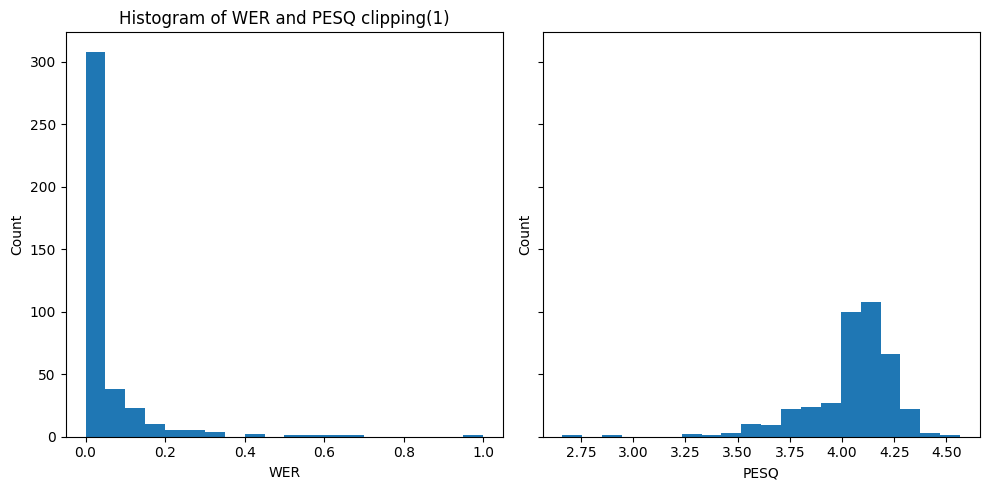

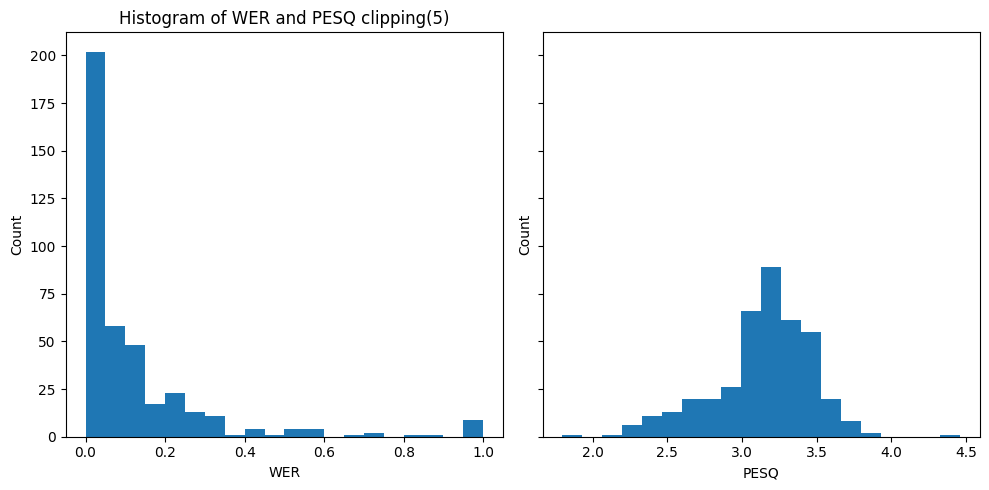

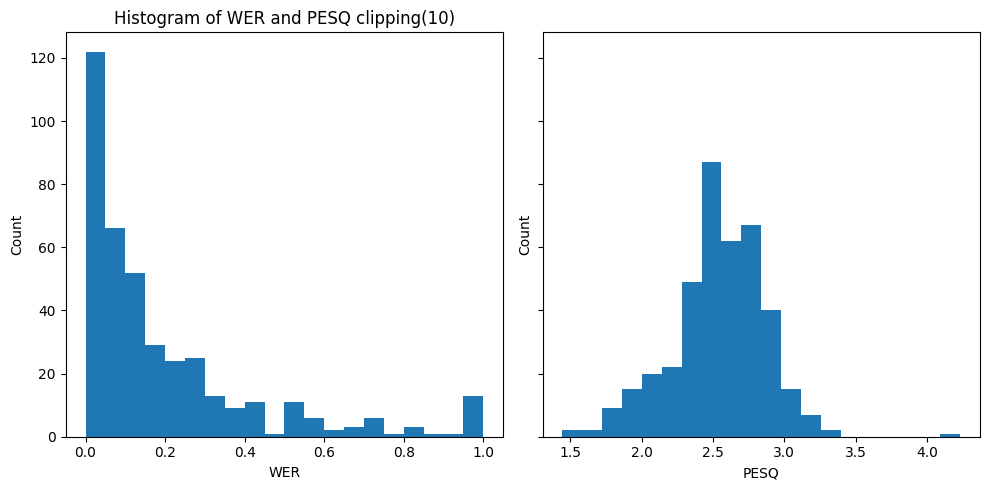

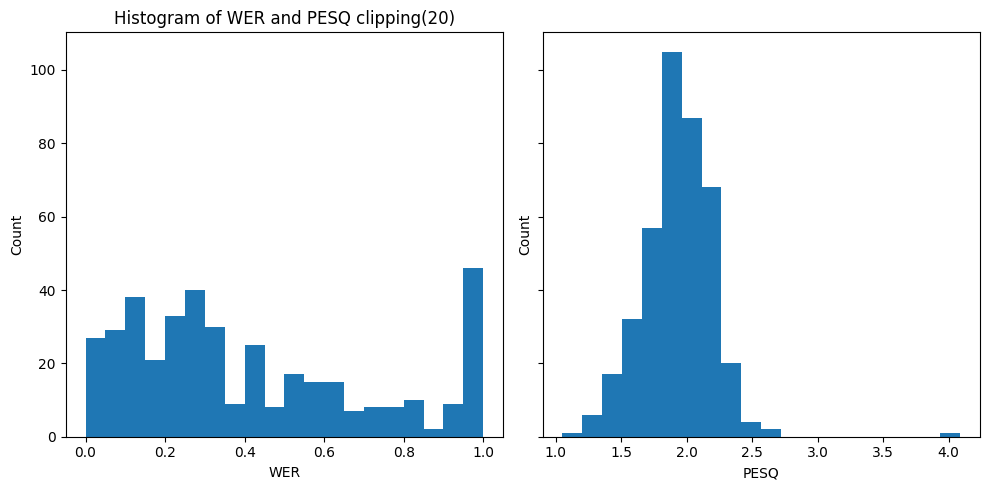

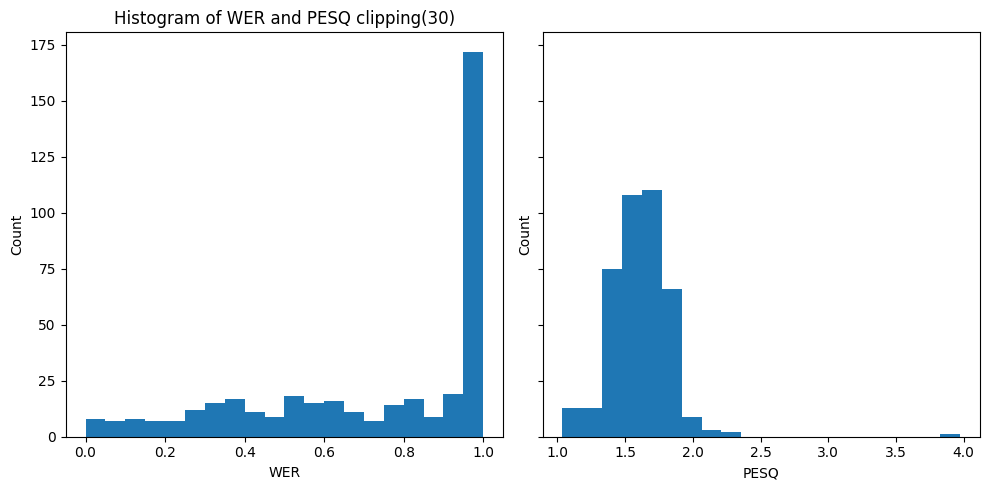

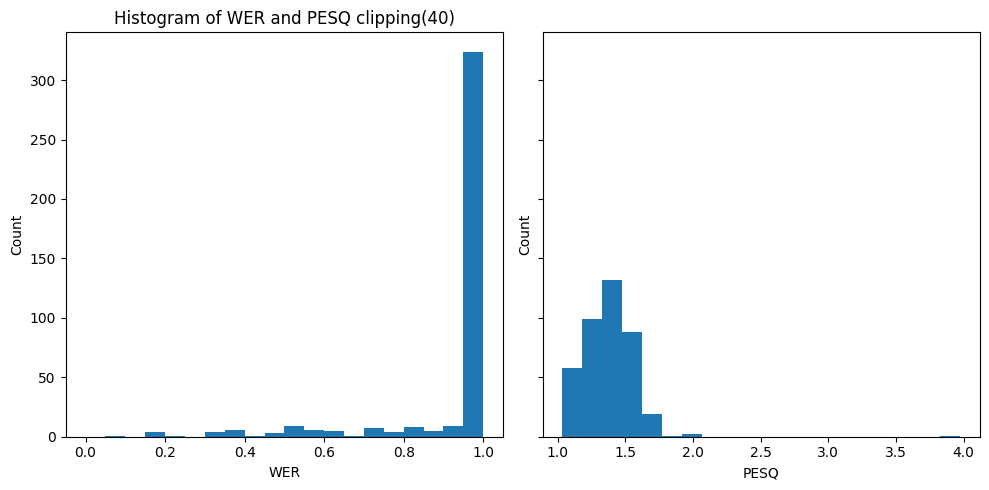

In [36]:
def plot_wer_pesq(output_file_path):
    # Read the output TSV file and group the data by clipping
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["clipping"] = [int(clipping) for clipping in data["clipping"]]

    # Group the data by clipping
    grouped_data = {}
    for clipping, wer, pesq in zip(data["clipping"], data["WER"], data["PESQ"]):
        if clipping not in grouped_data:
            grouped_data[clipping] = {"WER": [], "PESQ": []}
        grouped_data[clipping]["WER"].append(wer)
        grouped_data[clipping]["PESQ"].append(pesq)

    # Create subplots for each clipping level
    num_clippings = len(grouped_data)
    if num_clippings == 1:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
        axs = [axs]
    else:
        fig, axs = plt.subplots(num_clippings, 2, figsize=(10, 10), sharey=True)

    for i, (clipping, clipping_data) in enumerate(grouped_data.items()):
        # Create histograms for WER and PESQ scores
        axs[i][0].hist(clipping_data["WER"], range=(0, 1), bins=20)
        axs[i][1].hist(clipping_data["PESQ"], bins=20)

        # Add labels and titles
        axs[i][0].set_xlabel("WER")
        axs[i][1].set_xlabel("PESQ")
        if num_clippings == 1:
            axs[i][0].set_title(F"Histogram of WER and PESQ clipping({clipping})")
        else:
            axs[i][0].set_title(f"Histogram of WER (clipping {clipping})")
            axs[i][1].set_title(f"Histogram of PESQ (clipping {clipping})")
        axs[i][0].set_ylabel("Count")
        axs[i][1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

output_file_path = Path("OUTPUT1CLIP.tsv")
output_file_path1 = Path("OUTPUT5CLIP.tsv")
output_file_path2 = Path("OUTPUT10CLIP.tsv")
output_file_path3 = Path("OUTPUT20CLIP.tsv")
output_file_path4 = Path("OUTPUT30CLIP.tsv")
output_file_path5 = Path("OUTPUT40CLIP.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)
plot_wer_pesq(output_file_path5)



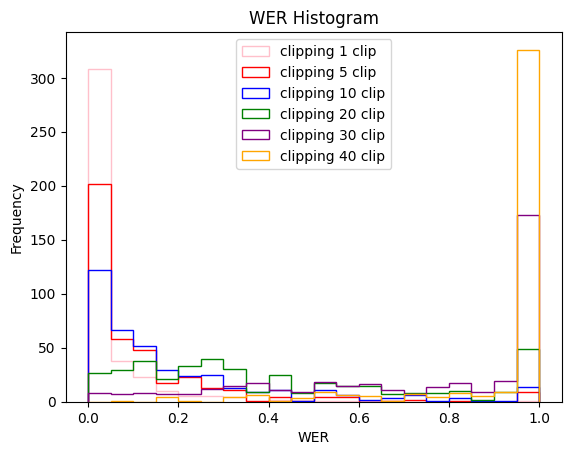

In [37]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer(output_file_path):
    # Read the output TSV file and group the data by clipping
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["clipping"] = [int(clipping) for clipping in data["clipping"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], 0, 1)

    return data["clipping"], data["WER"]

# Define colors for each clipping value
clipping_colors = {1: 'pink', 5: 'red', 10: 'blue', 20: 'green', 30: 'purple', 40: 'orange'}

output_file_paths = [Path("OUTPUT1CLIP.tsv"),Path("OUTPUT5CLIP.tsv"), Path("OUTPUT10CLIP.tsv"), Path("OUTPUT20CLIP.tsv"),
                     Path("OUTPUT30CLIP.tsv"), Path("OUTPUT40CLIP.tsv")]

wer_data = {}
for output_file_path in output_file_paths:
    clipping, wer = plot_wer(output_file_path)
    for clipping_value, wer_value in zip(clipping, wer):
        if clipping_value not in wer_data:
            wer_data[clipping_value] = []
        wer_data[clipping_value].append(wer_value)

plt.figure()
binwidth = 0.05
bins = np.arange(0, 1 + binwidth, binwidth)

for clipping_value, wer_values in wer_data.items():
    color = clipping_colors[clipping_value]
    plt.hist(wer_values, bins=bins, color=color, histtype='step', label=f'clipping {clipping_value} clip')

#plt.ylim(0, 250)

plt.xlabel("WER")
plt.ylabel("Frequency")
plt.title("WER Histogram")
plt.legend()
plt.show()


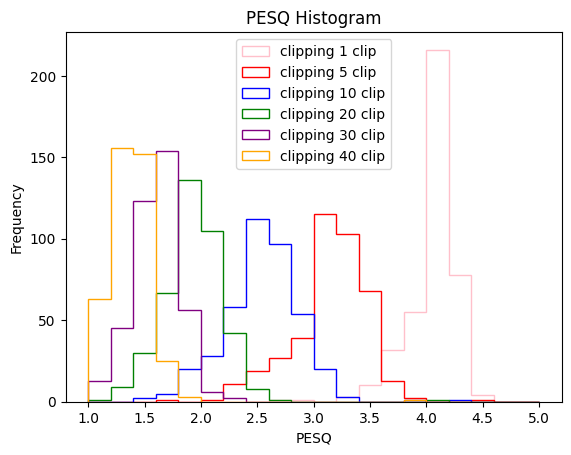

In [38]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pesq(output_file_path):
    # Read the output TSV file and group the data by clipping
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["clipping"] = [int(clipping) for clipping in data["clipping"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    return data["clipping"], data["PESQ"]

# Define colors for each clipping value
clipping_colors = {1: 'pink',5: 'red', 10: 'blue', 20: 'green', 30: 'purple', 40: 'orange'}

output_file_paths = [Path("OUTPUT1CLIP.tsv"),Path("OUTPUT5CLIP.tsv"), Path("OUTPUT10CLIP.tsv"), Path("OUTPUT20CLIP.tsv"),
                     Path("OUTPUT30CLIP.tsv"), Path("OUTPUT40CLIP.tsv")]

pesq_data = {}
for output_file_path in output_file_paths:
    clipping, pesq = plot_pesq(output_file_path)
    for clipping_value, pesq_value in zip(clipping, pesq):
        if clipping_value not in pesq_data:
            pesq_data[clipping_value] = []
        pesq_data[clipping_value].append(pesq_value)

plt.figure()
binwidth = 0.2
bins = np.arange(1, 5 + binwidth, binwidth)

for clipping_value, pesq_values in pesq_data.items():
    color = clipping_colors[clipping_value]
    plt.hist(pesq_values, bins=bins, color=color, histtype='step', label=f'clipping {clipping_value} clip')

plt.xlabel("PESQ")
plt.ylabel("Frequency")
plt.title("PESQ Histogram")
plt.legend()
plt.show()


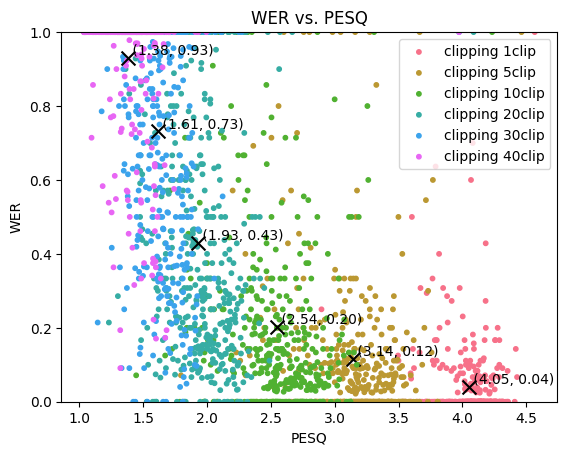

In [39]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

def plot_wer_pesq(output_file_paths):
    # Initialize an empty dictionary to store the grouped data
    grouped_data = {}
    
    for output_file_path in output_file_paths:
        # Read the output TSV file and group the data by clipping
        with open(output_file_path, "r") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            header = next(tsv_file)  # Skip header row
            for line in tsv_file:
                clipping = int(line[3])
                wer = float(line[1])
                pesq = float(line[2])
                
                if clipping not in grouped_data:
                    grouped_data[clipping] = {'WER': [], 'PESQ': []}
                
                grouped_data[clipping]['WER'].append(wer) 
                grouped_data[clipping]['PESQ'].append(pesq)
    
    # Create a color map using seaborn
    clipping_levels = sorted(grouped_data.keys())
    rgb_values = sns.color_palette("husl", len(clipping_levels))
    clipping_colors = dict(zip(clipping_levels, rgb_values))

    plt.figure()
    

    for clipping, data in grouped_data.items():
        wer = np.array(data['WER'])
        pesq = np.array(data['PESQ'])
        avg_wer = np.mean(wer)
        avg_pesq = np.mean(pesq)
        
        plt.scatter(pesq, wer, c=[clipping_colors[clipping]] * len(wer), label=f'clipping {clipping}clip', s=10)  # Set s=10 for smaller markers
        plt.scatter(avg_pesq, avg_wer, c='black', marker='x', s=100)
        plt.text(avg_pesq, avg_wer, f' ({avg_pesq:.2f}, {avg_wer:.2f})', fontsize=10, verticalalignment='bottom')



    plt.xlabel("PESQ")
    plt.ylabel("WER")
    plt.ylim(0,1)
    plt.title("WER vs. PESQ")
    plt.legend()
    plt.show()

output_file_paths = [
    Path("OUTPUT1CLIP.tsv"),
    Path("OUTPUT5CLIP.tsv"),
    Path("OUTPUT10CLIP.tsv"),
    Path("OUTPUT20CLIP.tsv"),
    Path("OUTPUT30CLIP.tsv"),
    Path("OUTPUT40CLIP.tsv"),
]

plot_wer_pesq(output_file_paths)
